## Initialisation

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import warnings
import pyfits as pf
from glob import glob
from pandas import DataFrame as DF
from astropy.time import Time
from scipy.signal import medfilt as mf
from scipy.ndimage import binary_erosion

from core import *


##Load bias and flatfield models

In [4]:
gain = pf.getval(l_obj[0], 'gain')
b1 = np.load(join(reddir,'bias_y.npz'))['ccd1_denoised']
b2 = np.load(join(reddir,'bias_y.npz'))['ccd2_denoised']

f1 = np.load(join(reddir,'masterflats.npz'))['flat_ccd1'] - b1[:,newaxis]
f2 = np.load(join(reddir,'masterflats.npz'))['flat_ccd2'] - b2[:,newaxis]

Define a function which creates lightcurves

In [5]:
def create_light_curve(o,s,center,width):
    lc = array([(o[i,:,center-width:center+width]-s[i,:,newaxis]).mean(1) for i in range(o.shape[0])])
    return lc/median(lc)

# Create Star Spectra

Bias and flatfield adjusted spectra for comparison and target stars

###Remove Bias

In [6]:
dco1 = gain*(pf.getdata('data/cube_o1.fits').astype(np.float64) - b1[newaxis,:,newaxis])
dcs1 = gain*(pf.getdata('data/cube_s1.fits').astype(np.float64) - b1[newaxis,:,newaxis])

dco2 = gain*(pf.getdata('data/cube_o2.fits').astype(np.float64) - b2[newaxis,:,newaxis])
dcs2 = gain*(pf.getdata('data/cube_s2.fits').astype(np.float64) - b2[newaxis,:,newaxis])

###Divide by the flatfield

In [7]:
#f1o=f1[:,245:350]
#f1o = array([f1o,]*651)
#dco1=dco1/f1o

#f1s=f1[:,370:450]
#f1s = array([f1s,]*651)
#dcs1=dcs1/f1s

#f2o=f2[:,840:895]
#f2o = array([f2o,]*651)
#dco2=dco2/f2o

#f2s=f2[:,770:810]
#f2s= array([f2s,]*651)
#dcs2=dcs2/f2s

In [8]:
sky1  = dcs1.mean(-1)
spectra_1 = create_light_curve(dco1,sky1,center=40,width=25)

sky2 = dcs2.mean(-1)
spectra_2 = create_light_curve(dco2,sky2,center=24,width=15)

## Save the spectra

In [9]:
pf.writeto(join(reddir,'spectra_1.fits'), spectra_1, clobber=True)
pf.writeto(join(reddir,'spectra_2.fits'), spectra_2, clobber=True)

/home/mert3269/Library/Python/2.7/lib/python/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/home/mert3269/soft/Parviainen-WASP-80b-Osiris/data/spectra_1.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/home/mert3269/Library/Python/2.7/lib/python/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/home/mert3269/soft/Parviainen-WASP-80b-Osiris/data/spectra_2.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


In [10]:
#data_dir = 'data/'
#sfiles_1 = sorted(glob(join(data_dir,'spectra_1.fits')))
#sfiles_2 = sorted(glob(join(data_dir,'spectra_2.fits')))

In [11]:
#with warnings.catch_warnings():
    #warnings.simplefilter('ignore', UserWarning)
    #spectra_1 = array([pf.getdata(sf, memmap=False) for sf in sfiles_1]).astype(np.float64)
    #spectra_2 = array([pf.getdata(sf, memmap=False) for sf in sfiles_2]).astype(np.float64)

##0 Flux Point Masking

An outlier (flux = 0 at time corresponding to ~318 pixel) has to be masked. Without masking, the outlier is so big that it completely changes the plots and makes them useless. We can see that this is not a point of interest as it affects both comparison and target stars at the same time. Here the transit is plotted without masking this point

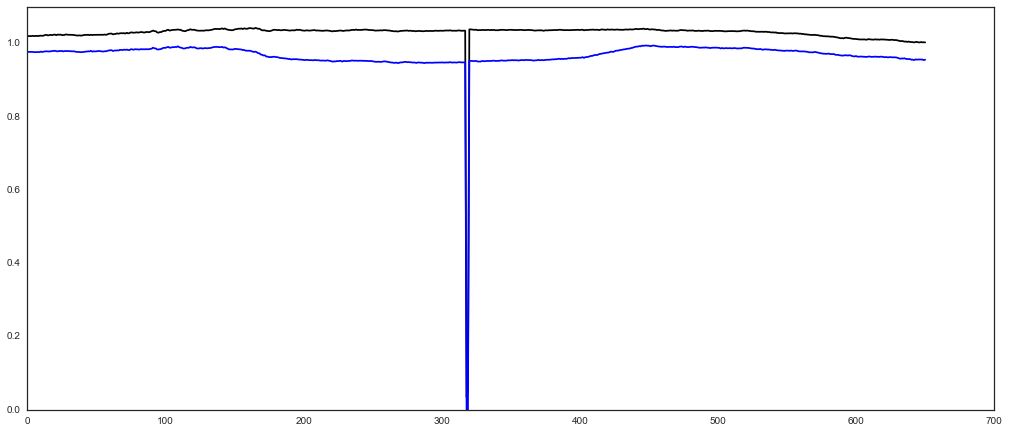

In [12]:
fig,ax = subplots(1,1,figsize=(14,6))
plot(spectra_1.mean(1)+0.05,'k')
plot(spectra_2.mean(1),'b')
ylim(0,1.1)
fig.tight_layout()

In [13]:
bmsk0 = ones(spectra_1.shape[0], np.bool)
bmsk0[317:320] = 0

In [14]:
spectra_1_paper = spectra_1[bmsk0]
spectra_2_paper = spectra_2[bmsk0]

## Read in the wavelength solutions 

The spectra have been extracted using a subsection from the original CCD (also along the dispersion axis), this must be accounted for when calculating the wavelength table.

In [15]:
wls = load(join('results','wl_calibration.pkl'), 'r')
pixels = arange(2051)
wl1 = wls['ccd1'].pixel_to_wl(pixels)
wl2 = wls['ccd2'].pixel_to_wl(pixels)

## Plot the spectra 

In [16]:
def normalise(lc, time_length = spectra_2_paper.shape[0]):
    msk = ones(time_length, np.bool)
    msk[140:450] = False         #transit time
    return lc / median(lc[msk])

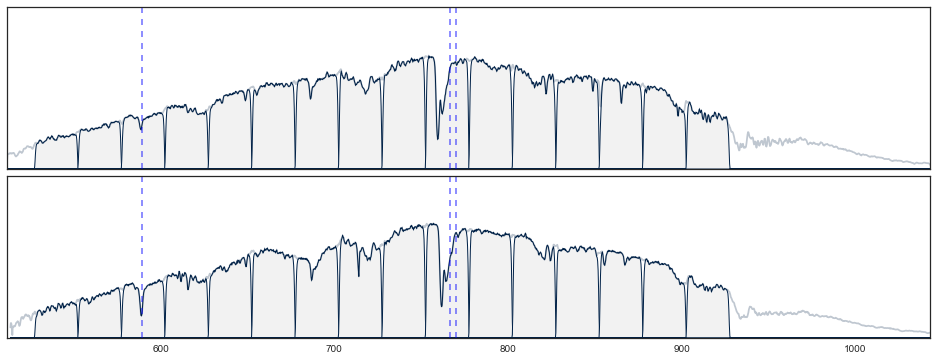

In [17]:
fig,axs = subplots(2,1, sharey=True, sharex=True)
wls = [wl1,wl2]
sps = [normalise(spectra_1_paper[0]),normalise(spectra_2_paper[0])]
aws = zip(axs,wls,sps)
[ax.plot(wl, sp, c=cp[0], alpha=0.25, zorder=1) for ax,wl,sp in aws]
[[ax.fill(wl, f(wl)*sp, ec=cp[0], lw=1, fc='0.95', zorder=0) for f in pb_filters_nb] for ax,wl,sp in aws]
[[a.axvline(wlc, ls='--', alpha=0.5, zorder=2) for wlc in r_[wlc_na,wlc_k]] for a in axs]
setp(axs, xlim=(wl1[[0,-1]]), ylim=(0,2.8), yticks=[])
fig.tight_layout()

## Create the spectrum mask

Telluric absorption can cause significant increase of noise in the narrow-band light curves. Here we create masks that remove the cores of the telluric absorption lines from the spectra. 

In [18]:
def create_mask(s, lims=None, elim=None, erosion_iterations=2, plot=True, figsize=(13,8), fs=12):
    x = arange(s.shape[0])
    if lims:
        tmask = (x < lims[0]) | (x > lims[1])
    else:
        tmask = ones(x.size, np.bool)
        
    p = poly1d(polyfit(x[tmask], s[tmask,:].mean(1), 4))
    
    lc_std = (s[tmask,:]/p(x[tmask])[:,newaxis]).std(0)
    smask  = binary_erosion(lc_std < elim, iterations=erosion_iterations, border_value=1)
    
    if plot:
        fig = figure(figsize=figsize)
        gs = GridSpec(2,2, width_ratios=(0.85,0.15), height_ratios=(0.6,0.4))
        axs = ae, ai, at = subplot(gs[0,0]), subplot(gs[1,0]), subplot(gs[1,1])
        ai.imshow(s, aspect='auto', interpolation='nearest', origin='lower')
       
        ae.plot(lc_std)
        ae.plot(0.035 + where(smask, lc_std, nan))
        ae.plot(where(smask, nan, -0.005), lw=3, c='k')   

        spec  = (s[tmask,:]/p(x[tmask])[:,newaxis]).mean(0)
        spec -= spec.min()
        spec /= spec.max()
        ae.plot(0.12+0.15*spec, alpha=0.5, c=cp[2])
        
        at.plot(s.mean(1), x, alpha=0.5)
        at.plot(p(x), x, 'k--', alpha=0.5)

        if lims is not None:
            ai.axhspan(*lims, ec='k', lw=2, fill=False, alpha=0.5)
            ai.axhspan(*lims, fc='w', ec='w', lw=1, fill=True, alpha=0.25)
            at.axhspan(*lims, ec='k', lw=2, fill=False, alpha=0.5)
            at.axhspan(*lims, fc='w', fill=True, alpha=0.25)

        if elim:
            ae.axhline(elim, ls='-', c=c_bo, alpha=0.25, zorder=-100)

        ae.text(0.01,0.94,'a', transform=ae.transAxes, size=fs)
        ai.text(0.97,0.88,'b', transform=ai.transAxes, size=fs)
        at.text(0.85,0.88,'c', transform=at.transAxes, size=fs)
            
        setp(ai, xlim=[0,s.shape[1]], ylim=x[[0,-1]], ylabel='Exposure', xlabel='Pixel')
        setp(ae, xlim=[0,s.shape[1]], xticks=[], ylim=(-0.015,0.28), ylabel='Normalized flux')
        setp(at, ylim=x[[0,-1]], yticks=[], xticks=[], xlabel='Relative flux')

        fig.tight_layout()
        sb.despine(ax=ae)
    
    return smask if not plot else smask,fig,axs

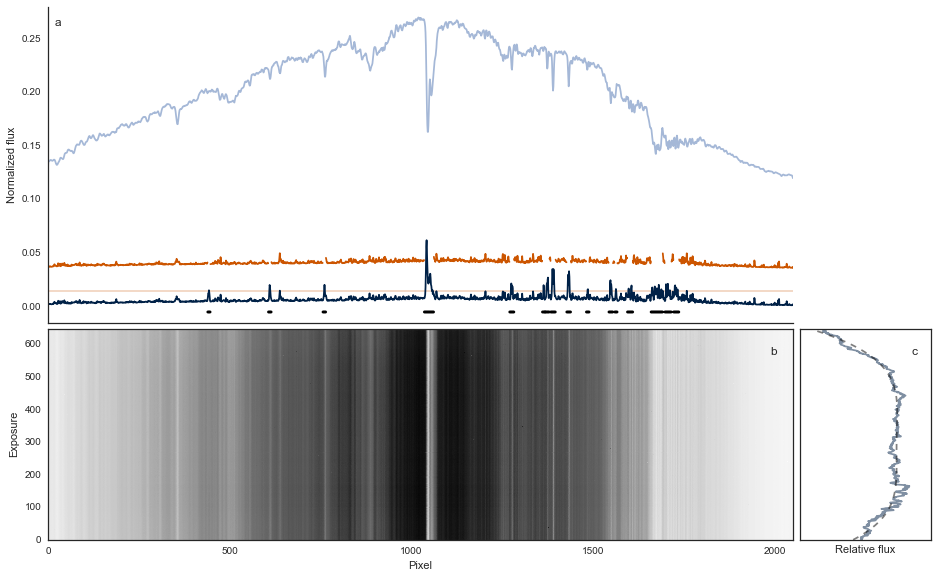

In [19]:
m1,f1,a1 = create_mask(spectra_1_paper/median(spectra_1_paper), elim=0.015, erosion_iterations=3)

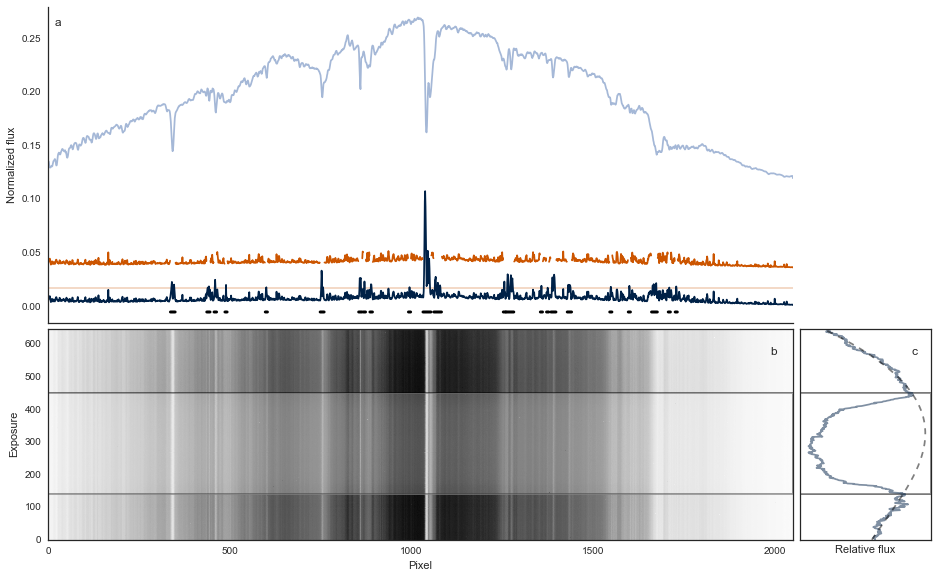

In [20]:
m2,f2,a2 = create_mask(spectra_2_paper/median(spectra_2_paper), lims=(140,450), elim=0.0175, erosion_iterations=3)

## Create the bad-point mask 

In [21]:
bmsk = ones(spectra_1_paper.shape[0], np.bool)
#bmsk[317:320] = 0
bmsk[630:] = 0

## Create the light curves

The light curves are name as `lc_BB_N_MMMMMM` where `BB` is either `nb` for a narrow band or `bb` for the broad passband, `N` is 1 for the reference star and `2` for TrES-3, and `MMMMMM` is either `mask` or `nomask`.

In [22]:
lc_nb_1_nomask = array([[mean(f(wl1)*s) for f in pb_filters_nb] for s in spectra_1_paper])
lc_nb_2_nomask = array([[mean(f(wl2)*s) for f in pb_filters_nb] for s in spectra_2_paper])
lc_nb_1_masked = array([[nanmean(f(wl1)*where(m1,s,nan)) for f in pb_filters_nb] for s in spectra_1_paper])
lc_nb_2_masked = array([[nanmean(f(wl2)*where(m2,s,nan)) for f in pb_filters_nb] for s in spectra_2_paper])

In [23]:
lc_bb_1_nomask = array([mean(pb_filter_bb(wl1)*s) for s in spectra_1_paper])
lc_bb_2_nomask = array([mean(pb_filter_bb(wl2)*s) for s in spectra_2_paper])
lc_bb_1_masked = array([nanmean(pb_filter_bb(wl1)*where(m1,s,nan)) for s in spectra_1_paper])
lc_bb_2_masked = array([nanmean(pb_filter_bb(wl2)*where(m2,s,nan)) for s in spectra_2_paper])

In [24]:
lc_bb_nomask = normalise(lc_bb_2_nomask/lc_bb_1_nomask)
lc_bb_masked = normalise(lc_bb_2_masked/lc_bb_1_masked)
lc_nb_nomask = array([normalise(lc) for lc in (lc_nb_2_nomask/lc_nb_1_nomask).T]).T
lc_nb_masked = array([normalise(lc) for lc in (lc_nb_2_masked/lc_nb_1_masked).T]).T

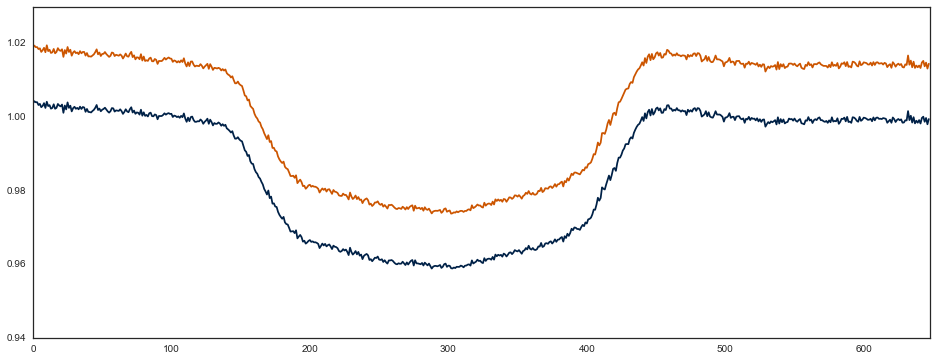

In [39]:
fig,ax = subplots(1,1)
ax.plot(lc_bb_nomask)
ax.plot(0.015+lc_bb_masked)
setp(ax, xlim=[0,lc_nb_2_nomask.shape[0]], ylim=[0.94,1.03])
fig.tight_layout()

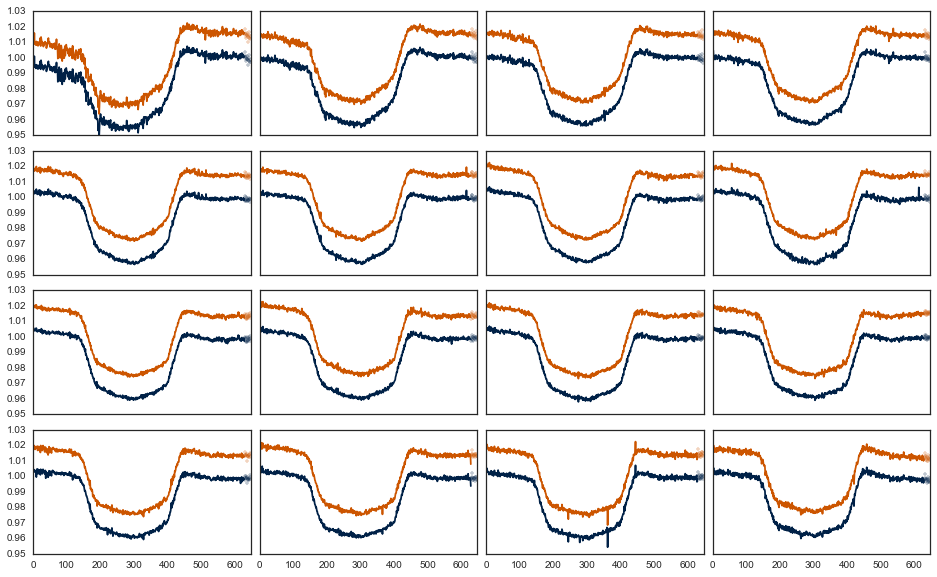

In [26]:
fig,axs = subplots(4,4,figsize=(13,8), sharey=True, sharex=True)
for i,a in enumerate(axs.flat):
    lcr =  normalise(lc_nb_2_nomask[:,i]/lc_nb_1_nomask[:,i])
    lcm =  normalise(lc_nb_2_masked[:,i]/lc_nb_1_masked[:,i])
    a.plot(where(bmsk, lcr, nan), c=cp[0])
    a.plot(where(bmsk, nan, lcr), '.', c=cp[0], alpha=0.25)
    a.plot(where(bmsk, 0.015+lcm, nan), c=cp[1])
    a.plot(where(bmsk, nan, 0.015+lcm), '.', c=cp[1], alpha=0.25)
setp(axs, xlim=[0,lc_nb_2_nomask.shape[0]], ylim=[0.95,1.03])
fig.tight_layout()

## Get the auxiliary parameters

In [27]:
time, airmass, humidity, pressure = [],[],[],[]

l_obj_masked = [l_obj[i] for i in xrange(len(l_obj)) if bmsk0[i]]

for fn in l_obj_masked:
    f = pf.open(fn)
    time.append(f[0].header['date-obs'])
    airmass.append(f[0].header['airmass'])
    humidity.append(f[0].header['humidity'])
    pressure.append(f[0].header['pressure'])
    f.close()
mjd = Time(time).mjd

df_aux = pd.DataFrame(transpose([mjd,airmass,humidity,pressure,bmsk]), 
                  columns='mjd airmass humidity pressure bad_mask'.split())

In [28]:
df_filters = pd.DataFrame(transpose([f(wl2) for f in pb_filters_nb]), columns=pb_centers)

In [29]:
df_aux[315:321]

,mjd,airmass,humidity,pressure,bad_mask
315,56894.948030,1.170389,15.381894,782.429993,1
316,56894.948302,1.170183,15.282119,782.440002,1
317,56894.951786,1.167800,15.231270,782.460022,1
318,56894.952058,1.167634,15.231270,782.450012,1
319,56894.952330,1.167480,15.226954,782.450012,1
320,56894.952602,1.167322,15.215919,782.460022,1


## Write the light curves and the auxiliary data into a HDF5 file 

In [30]:
bbargs = dict(columns=['white'], index=mjd)
nbargs = dict(columns=pb_centers, index=mjd)

with pd.HDFStore('results/light_curves.h5') as hdf:
    hdf.put('aux', df_aux, format='table', data_columns=True)
    hdf.put('filters', df_aux, format='table', data_columns=True)
    hdf.put('bad_exposures', pd.Series(bmsk0), format='table')
    hdf.put('final/bb_nomask',     DF(lc_bb_nomask,   **bbargs), data_columns=True)
    hdf.put('final/bb_masked',     DF(lc_bb_masked,   **bbargs), data_columns=True)
    hdf.put('final/nb_nomask',     DF(lc_nb_nomask,   **nbargs), data_columns=True)
    hdf.put('final/nb_masked',     DF(lc_nb_masked,   **nbargs), data_columns=True)
    hdf.put('target/bb_nomask',    DF(lc_bb_2_nomask, **bbargs), data_columns=True)
    hdf.put('target/bb_masked',    DF(lc_bb_2_masked, **bbargs), data_columns=True)
    hdf.put('target/nb_nomask',    DF(lc_nb_2_nomask, **nbargs), data_columns=True)
    hdf.put('target/nb_masked',    DF(lc_nb_2_masked, **nbargs), data_columns=True)
    hdf.put('reference/bb_nomask', DF(lc_bb_1_nomask, **bbargs), data_columns=True)
    hdf.put('reference/bb_masked', DF(lc_bb_1_masked, **bbargs), data_columns=True)
    hdf.put('reference/nb_nomask', DF(lc_nb_1_nomask, **nbargs), data_columns=True)
    hdf.put('reference/nb_masked', DF(lc_nb_1_nomask, **nbargs), data_columns=True)

## Create the plots for the paper

All plots have the outlier of 0 flux masked

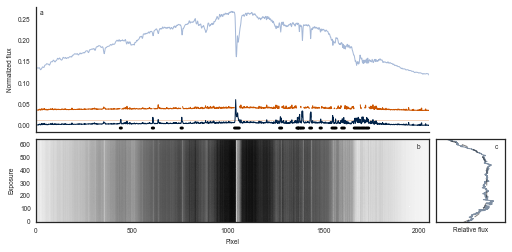

In [32]:
with sb.plotting_context('paper', rc=rc_paper):
    m1,f1,a1 = create_mask(spectra_1_paper/median(spectra_1_paper), elim=0.015,
                           erosion_iterations=3, figsize=(AAPGW,AAOCW), fs=6.5)
    f1.savefig('plots/pub_smask_c.pdf')

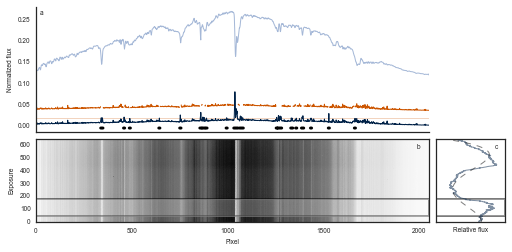

In [33]:
with sb.plotting_context('paper', rc=rc_paper):
    m2,f2,a2 = create_mask(spectra_2_paper/median(spectra_2_paper), lims=(45,180), elim=0.0175, 
                           erosion_iterations=3, figsize=(AAPGW,AAOCW), fs=6.5)
    f2.savefig('plots/pub_smask_t.pdf')

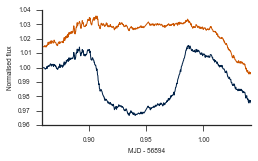

In [35]:
with sb.plotting_context('paper', rc=rc_paper):
    with sb.axes_style('ticks'):
        time = array(df_aux.mjd) - floor(df_aux.mjd[0])
        fig,ax = subplots(1,1, figsize=(AAOCW,0.6*AAOCW))
        ax.plot(time, lc_bb_2_nomask/lc_bb_2_nomask[0], c=c_ob, lw=1)
        ax.plot(time, lc_bb_1_nomask/lc_bb_1_nomask[0] +0.015, c=c_bo, lw=1)
        setp(ax, xlim=time[[0,-1]], ylabel='Normalised flux', xlabel='MJD - {:5.0f}'.format(floor(df_aux.mjd[0])))
        sb.despine(fig)
        fig.tight_layout()
        fig.subplots_adjust(left=0.15, right=0.99, bottom=0.20, top=0.97)
        fig.savefig('plots/pub_lc_bb_raw.pdf')


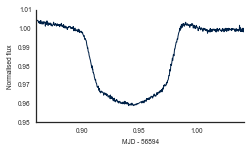

In [37]:
with sb.plotting_context('paper', rc=rc_paper):
    fig,ax = subplots(1,1, figsize=(AAOCW,0.6*AAOCW))
    plot(time, normalise(lc_bb_2_nomask/lc_bb_1_nomask), c=c_ob)
    setp(ax, xlim=time[[0,-1]], ylim=(0.95,1.01), ylabel='Normalised flux', 
         xlabel='MJD - {:5.0f}'.format(floor(df_aux.mjd[0])))
    fig.tight_layout()
    sb.despine(fig)
    fig.savefig('plots/pub_lc_bb_rel.pdf')

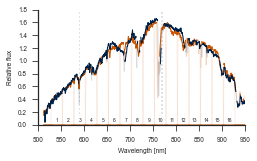

In [38]:
df = 1.1
sc,st = spectra_1_paper[0]/df, spectra_2_paper[0]/df

with sb.plotting_context('paper', rc=rc_paper):
    with sb.axes_style('ticks'):
        fig,ax = subplots(1,1,figsize=(AAOCW,0.6*AAOCW))
        [ax.plot(wl1, f(wl1)*sc, c=c_bo, lw=1, alpha=0.1, zorder=-100) for f in pb_filters_nb]
        ax.plot(wl1, sc, c=c_bo, lw=1, alpha=0.15, zorder=100)
        ax.plot(wl1, where(m1, sc, nan), c=c_bo, lw=1, alpha=1, zorder=100)
        ax.plot(wl2, st, c=c_ob, lw=1, alpha=0.15, zorder=101)
        ax.plot(wl2, where(m2, st, nan), c=c_ob, lw=1, alpha=1, zorder=101)
        [ax.text(pbc, 0.06, i+1, ha='center', size=5, bbox=dict(facecolor='white', edgecolor='white')) 
         for i,pbc in enumerate(pb_centers)]
        [ax.axvline(wlc, c=cp[0], alpha=0.25, ls=':', lw=1, zorder=-100) for wlc in r_[wlc_k,wlc_na]]
        sb.despine(fig)
        setp(ax, xlabel='Wavelength [nm]', xlim=(500,950), ylim=(0,1.8), ylabel='Relative flux')
        fig.subplots_adjust(left=0.13, right=0.96, bottom=0.20, top=0.97)
        fig.savefig('plots/pub_spectra.pdf')

---
<center> &copy; 2015 <a href="mailto:hannu.parviainen@physics.ox.ac.uk">Hannu Parviainen</a></center>